## Generate bathymetry binary files for the tank - no canyon case 

This notebook guides you in building the binary files necessary to run the MITgcm UBC LabCanyons model without canyons.

In [1]:
import cmocean as cmo
import matplotlib.cm as cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import time
%matplotlib inline

In [2]:
sns.set_style('whitegrid')
sns.set_context('talk')

In [3]:
def tanktopo(r, r_tank, r_deep, r_shelf, r_step, h_wall, h_sbreak, h_deep, tot_water_depth): # OK
    
    ''' This function generates the topographical profile of the continental
    slope and shelf without the canyon. The profile is created in parts using
    the equation of a line: topography = z2 = (m * y2) - (m* y1) + z1, where
    the values for y represent key distances along the cross-shore direction
    and the values for z2 are the calculated depths based on a known z1 depth.
    '''
    
    m_shelf = (h_wall - h_sbreak) / (r_tank - r_shelf) # shelf inclination
    m_slope = (h_sbreak - h_deep) / (r_shelf - r_deep) # slope inclination
    
    shelf_profile = np.zeros(len(r)) # z values of the shelf profile
   
    for jj in np.arange(len(r)):
        
        if r[jj] <= r_step: # Step at the centre of the tank
            shelf_profile[jj] = tot_water_depth 
        
        elif r[jj] > r_step and r[jj] < r_deep:
            shelf_profile[jj] = h_deep 
        
        elif r[jj] >= r_deep  and r[jj] <= r_shelf :
                shelf_profile[jj] = (m_slope * r[jj]) - (m_slope * r_deep) + h_deep 

        elif r[jj] > r_shelf and r[jj] <= r_tank:
            shelf_profile[jj] = (m_shelf * r[jj]) - (m_shelf * r_shelf) + h_sbreak
    
                                  
    return shelf_profile



#----------------------------------------------------------------------------------
def canyontopo(r, r_deep, r_sbreak, r_head, r_tank,
               h_deep, h_sbreak, h_wall): # canyon thalweg
    
    ''' This function generates the topographical profile for the canyon along
    its axis (cross-shore direction). Similar to tanktopo, the profile is
    formed using a collection of lines.
    '''
    slc_ct = (h_wall - h_sbreak) / (r_tank - r_shelf) # shelf slope
    
    h_head = slc_ct * (r_head - r_tank) + h_wall # head depth
    print('head depth is %1.3f m' %h_head)
    slc_L = (h_head - h_deep) / (r_head - r_deep) # axis slope
    
    topo_cp = np.zeros(len(r))
    canyon_profile = np.zeros(len(r))
    
    for ii in np.arange(len(r)):
        
        if r[ii] <= r_deep:
            topo_cp[ii] = h_deep
    
        elif r[ii] > r_deep and r[ii] <= r_head:
            topo_cp[ii] = (slc_L * r[ii]) - (slc_L * r_deep) + h_deep
                    
        elif r[ii] > r_head and r[ii] <= r_tank :      
            topo_cp[ii] = (slc_ct * r[ii]) - (slc_ct * r_sbreak) + h_sbreak
          
        elif r[ii] > r_tank:
            topo_cp[ii] = h_wall
        
        canyon_profile[ii] = topo_cp[ii] 
 
    return canyon_profile

#----------------------------------------------------------------------------------
   
def widthprofile(r, r_deep, r_shelf, r_head, r_tank, cR, L,
                 w_break, w_mid, w_head, p):
    
    ''' This function defines the width profile of the canyon (top-down view).
    The width of the canyon is defined for all distances in the cross-shore
    direction. 
    '''

    sigmaa = 1.0 / ((9e-7) * cR)
    half = -w_break / 2.0 + w_mid / 2.0
    e = (L / 2.0 - sigmaa * half**2) / half**p 
    sc = 1
    dG_dxh = p * e * (w_head - w_break / 2)**(p-1) + 2 * sigmaa * (w_head - w_break)
    dh = 0.5 / dG_dxh / sc
    Ah = (w_break - w_head) / (r_shelf - r_head)**2; #(w_break - w_head) / (r_deep - r_head)**2; 
    wp = np.zeros(len(r))

    for ii in np.arange(len(r)):

            if r[ii] < r_deep:
                wp[ii] = w_break

            elif r[ii] >= r_deep and r[ii] <= r_head:   
                wp[ii] = Ah * (r[ii] - r_head)**2 + dh * (r[ii] - r_head) + w_head

            elif r[ii] > r_head and r[ii] <= r_tank:
                wp[ii] = wp[ii-1]
            
            elif r[ii] > r_tank:
                wp[ii] = w_break
                
    width_profile = wp 
    return width_profile
#----------------------------------------------------------------------------------

def make_topo_smooth(y, y_base, y_break, y_head, y_coast, cR, L,
                     x, x_wall, w_break, w_mid, w_head, p,
                     fluid_depth, z_bottom, z_break, z_wall, B):
    
    ''' This function returns the depth field of the continental slope and
    shelf with a sech-shaped canyon. It uses the functions tanktopo,
    canyontopo, and widthprofile.
    
    :arg y: Array of cross-shore distances
    :arg y_base: Distance to the base of the continental slope
    :arg y_break: Distance to the shelf break
    :arg y_head: Distance to the canyon head
    :arg y_coast: Distance beyond y_head where shelf flattens
    :arg cR: Radius of curvature at the shelf break depth
    :arg x: Array of alongshore distances
    :arg x_wall: Width of the Domain
    :arg w_break: Width of the canyon at the shelf break
    :arg w_mid: Width of the canyon half-way along its length
    :arg w_head: Width of the canyon head
    :arg p: Geometric parameter used to help shape of canyon
    :arg fluid_depth: Total height of the fluid in the domain.
    :arg z_bottom: Depth of the deep ocean (measured upward)
    :arg z_break: Depth of the shelf break (measured upward)
    :arg z_wall: Depth of shelf beyond y_coast (measured upward)
    '''
    
    # Topography without the canyon
    slope_profile = tanktopo(y, y_base, y_break, y_coast,
                             fluid_depth, z_bottom, z_break, z_wall)
    
    # Slope of the canyon
    canyon_profile = canyontopo(y, y_base, y_break, y_head, y_coast,
                                fluid_depth, z_bottom, z_break, z_wall)
  
    # Slope of the canyon as well as the shape
    width_profile = widthprofile(y, y_base, y_break, y_head, y_coast, cR, L,
                                 w_break, w_mid, w_head, p)
  
    # Depth of the canyon (negative values set to zero)
    canyondepth = slope_profile - canyon_profile
  
    canyondepth[canyondepth < 0] = 0
  
    # Sech shaped canyon
    topography = np.zeros((len(y),len(x)))
    for j in np.arange(len(x)):
        topography[:,j] = (slope_profile - canyondepth * 
                           (1.0 / (np.cosh(0.5 / width_profile * (x[j] - (B))))**50))
    #topography=np.transpose(topography)
    topo = -1* topography[0:-1, :]
   
    return topo
#----------------------------------------------------------------------------------

def set_domain_grid(xsize, ysize, x_wall, y_wall):
    
    ''' Sets up the domain dimensions and grid cells used
    to generate the canyon bathymetry.
    
    :arg xsize: X direction dimension (alongshore)
    :arg ysize: Y direction dimension (cross-shore)
    '''
    
    xgrd_all = np.arange(0, xsize, 1)
    xgrd_bounds = [0, xsize-1]
    xval_bounds = [0, x_wall]
    xval_all = np.interp(xgrd_all, xgrd_bounds, xval_bounds)
    x_edge = np.zeros(xsize)
    x_edge[:] = xval_all[:]
    x = ((x_edge[1:] + x_edge[0:-1])/2)

    ygrd_all = np.arange(0, ysize, 1)
    ygrd_bounds = [0, ysize-1]
    yval_bounds = [0, y_wall]
    yval_all = np.interp(ygrd_all, ygrd_bounds, yval_bounds)
    y_edge = np.zeros(ysize)
    y_edge[:] = yval_all[:]
    y = ((y_edge[1:] + y_edge[0:-1])/2)

    X, Y = np.meshgrid(x, y)
    
    return x, y, y_edge, X, Y
#----------------------------------------------------------------------------------

def create_bathy_file(X, Y, bathymetry, filename, title, description):
    
    """ This function creates a netCDF4 file for
    the canyon bathymetry given the filename and 
    the x and y grid cell number.
    
    :arg X: Alongshore indices (from set_domain_grid)
    :arg Y: Cross-shore indices (from set_domain_grid)
    :arg bathymetry: Canyon bathymetry (from make_topo_smooth)
    :arg filename: Directory and name of netcdf file
    :arg title: Title of bathymetry version
    :arg description: Details about bathymetry version
    """
    
    dataset = Dataset(filename, 'w')
    file_x = dataset.createDimension('x', X.shape[1])
    file_y = dataset.createDimension('y', X.shape[0])

    file_X = dataset.createVariable('X', 'f8', ('y','x'))
    file_Y = dataset.createVariable('Y', 'f8', ('y','x'))
    Bathymetry = dataset.createVariable('Bathymetry', 'f8', ('y','x'))

    dataset.title = title
    dataset.author = 'Karina Ramos Musalem'
    dataset.institution = 'Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia'
    dataset.source = 'bitbucket.org/CanyonsUBC/BuildCanyon/Bathymetry/GenerateTankBathymetry_Inserts.ipynb'
    dataset.description = description
    dataset.timeStamp = time.ctime(time.time())
    file_X.standard_name = 'Alongshelf Distance'
    file_X.units = 'm'
    file_Y.standard_name = 'Cross-shelf Distance'
    file_Y.units = 'm'
    Bathymetry.standard_name = 'Bathymetry'
    Bathymetry.units = 'm'
    Bathymetry.positive = 'upward'

    file_X[:] = X[:]
    file_Y[:] = Y[:]
    Bathymetry[:] = bathymetry[:]

    dataset.close()
    

In [4]:
# Cross-shore
cR = 0.014                 # m, Radius of curvature 
L = 0.12                   # m, Canyon length

# Radii (very similar to cross-shore dimensions. These distances are the ones used instead of y_*)
r_tank = 0.5   #0.495           # m, radius of the tank, ignore plexiglass step around the tank
r_deep = r_tank - 0.283 #0.275  # m, distance from deepest part of the slope to the centre of the tank
r_shelf = r_tank - 0.215  # m, horizontal, cross-shelf distance to the shelf - the shelf is 22.3 cm long
r_slope = 0.283-0.215 # m, horizontal distance from shelf-break to deep "ocean"
r_head = r_shelf + L    
r_step = 0.2*r_tank # m, horizontal distance from step to tank centre. 
                    # Step is added for numerical stability. Dawe and Allen (2010)
                    # use a 10 cm step (20% of tank radius)
# Insert's angular width
arc_length = 2*r_tank*np.pi # arc length to plot
arc_insert = 0.185 # 0.175 (most of the inserts are 17.5-18 cm)
ini_insert = ((arc_length/2)-(arc_insert/2))/r_tank
end_insert = ((arc_length/2)+(arc_insert/2))/r_tank

th_length = arc_length/r_tank # rad, angular width of the insert and adjacent shelf
B = th_length/2.0               # parameter used to center the canyon axis in the middle of the insert    

th_insert = arc_insert/r_tank # rad, angular width of the insert.
B_ins = th_insert/2.0               # parameter used to center the canyon axis in the middle of the insert    

# Alongshore
w_break = 0.080/r_shelf         # rad, canyon width at shelf break (in arc long)
w_mid = 0.05/(r_shelf + (L/2))           # rad, canyon width at mid-length
w_head = 0.03/(r_shelf + L)          # rad, canyon width near the head
width_f = 0.080/r_shelf         # rad, canyon width at shelf break (can't this just be w_break? )
x_wall = width_f * 7          # rad, make total alongshore distance be 7 times the canyon width

# Adjustments
mouth = 0.21
length = 0.12
y_wall = r_tank # (mouth + length) * 2.0
C = 150         # Exponent of the sech function

# Depths
h_wall = 0.09   # m, height of insert at tank wall (max height) (0.085 for insert)
h_deep = 0.0     # m, height of deep ocean
h_sbreak = 0.066 # m, height at shelf break (0.068 for insert)
    
# Water column
tot_water_depth = 0.095 # m, has to be positive

p = 4 # ?? Width profile does not seem to change much when I change this, I tried 0,4,100 

In [5]:
# Number of grid points along radial and azimuthal directions
rsize = 30  # Coarse version value 
thsize = 120 # Coarse version value

r = np.linspace(0.1,r_tank,rsize)
th =  np.linspace(0,th_length,thsize)

r_mesh, th_mesh = np.meshgrid(r,th)

# Grid spacing vectors
delr = r[1:]-r[:-1]
del_r = np.append(delr,[delr[-1]],axis=0) # Cheating! not cool if mesh is non-uniform
delth = ((th[1:]-th[:-1])*180)/np.pi
del_th = np.append(delth,[delth[-1]],axis=0) # Cheating! not cool if mesh is non-uniform

In [6]:
shelf_shape = tanktopo(r, r_tank, r_deep, r_shelf, r_step, h_wall, h_sbreak, h_deep, tot_water_depth)

In [7]:
### No canyon bathymetry

# Shelf shape profile
canyondepth = shelf_shape 
canyondepth[canyondepth < 0] = 0

# Subtract total water column depth to get depths. 
topography = np.zeros((len(th),len(r)))
for jj in np.arange(len(th)):
    topography[jj,:] = shelf_shape-tot_water_depth

# Add tank wall (z = 0 m)
topography[:,-1] = 0

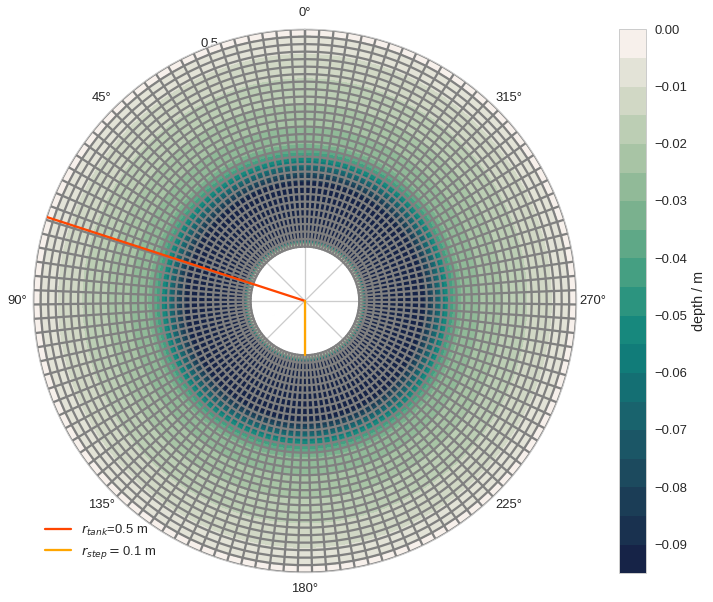

In [8]:
fig = plt.figure(figsize=(15,10))
ax2 = fig.add_subplot(111, polar=True)

cmesh = ax2.contourf(th_mesh, r_mesh, topography,20, cmap = cmo.cm.tempo_r)

cb = plt.colorbar(cmesh)
cb.set_label('depth / m')

#ax2.contour(th_mesh, r_mesh, topography,20, colors=['0.5'], linestyles='-')


for rr in r:
    ax2.plot(th,np.ones(thsize)*rr, '-', color='gray')
for tt in th:
    ax2.plot(tt*np.ones(rsize),r, '-', color='gray')

ax2.plot(np.ones(30)*(0.4*np.pi),np.linspace(0,r_tank,30), '-', color='orangered',label=r'$r_{tank}$=%1.1f m' %r_tank )
ax2.plot(np.ones(30)*(np.pi),np.linspace(0,r_step,30), '-', color='orange',label=r'$r_{step}=$%1.1f m' %r_step )

ax2.set_rlim(0,0.5)
ax2.set_thetamin(np.min(th_mesh)*360/(2*np.pi))
ax2.set_thetamax(np.max(th_mesh)*360/(2*np.pi))
ax2.set_theta_zero_location('N', offset=0)

ax2.legend(loc=3)
plt.savefig('tank/no_canyon_coarse_MITgcm.pdf',orientation='portrait', papertype='letter', format='pdf',pad_inches=0.0)


Make sure that the cells are as squared as possible

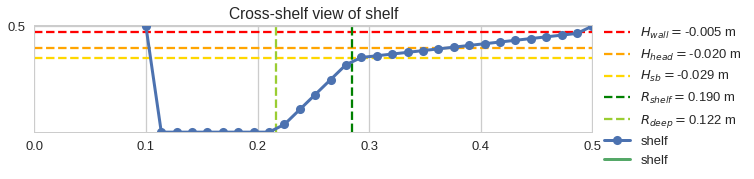

In [11]:
fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(111)

ax2.axhline(h_wall-tot_water_depth,linestyle='--', color='red', label='$H_{wall}=$%1.3f m' %(h_wall-tot_water_depth))
ax2.axhline(0.075-tot_water_depth,linestyle='--', color='orange', label='$H_{head}=$%1.3f m' %(0.075-tot_water_depth))
ax2.axhline(h_sbreak-tot_water_depth,linestyle='--', color='gold', label='$H_{sb}=$%1.3f m' %(h_sbreak-tot_water_depth))
ax2.axvline(r_shelf,linestyle='--', color='green', label='$R_{shelf}=$%1.3f m' %(r_shelf-tot_water_depth))
ax2.axvline(r_deep,linestyle='--', color='yellowgreen', label='$R_{deep}=$%1.3f m' %(r_deep-tot_water_depth))

cmesh = ax2.plot(r, topography[10,:],'-o','0.5',linewidth=3,label='shelf')

ax2.set_title('Cross-shelf view of shelf')

ax2.set_ylim(-tot_water_depth,0.001)
ax2.set_xlim(0.0,0.50)
ax2.legend(bbox_to_anchor=(1,1.1), ncol=1)
ax2.set_aspect(1)
plt.savefig('tank/no_canyon_coarse_shelf_profile_MITgcm.pdf', format='pdf',pad_inches=0.0)

**In rectangular coordinates (just checking)**

In [12]:
x_mesh = r_mesh*np.cos(th_mesh)
y_mesh = r_mesh*np.sin(th_mesh)

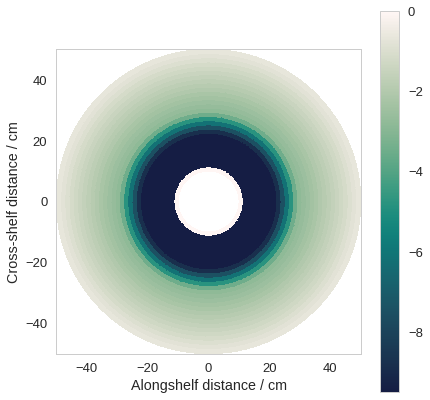

In [13]:
# No canyon insert
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
cmesh = ax.pcolormesh(y_mesh*100, x_mesh*100, topography*100, cmap = cmo.cm.tempo_r)
cb = plt.colorbar(cmesh, ax=ax)
ax.set_ylabel('Cross-shelf distance / cm')
ax.set_xlabel('Alongshelf distance / cm')
ax.set_aspect(1)


**3D bathymetry, why not?**

Text(0.5,0,'Depth / cm')

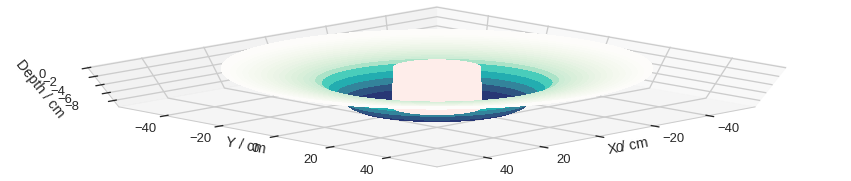

In [14]:
# Plot 3D bathymetry
plt.rcParams['contour.negative_linestyle'] = 'solid' 

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ls = LightSource(180, 50)
rgb = ls.shade(topography*100, cmap=cmo.cm.tempo_r, vert_exag=0.1, blend_mode='soft')

# ax1
p = ax.plot_surface(x_mesh*100, y_mesh*100, topography*100, rstride=1, cstride=1, 
                    facecolors=rgb,linewidth=0.5, antialiased=False, shade=False)

ax.set_aspect(0.2)
ax.view_init(65, 45) # elevation and azimuth
ax.set_ylabel('Y / cm')
ax.set_xlabel('X / cm')
ax.set_zlabel('Depth / cm')


### Save binary file

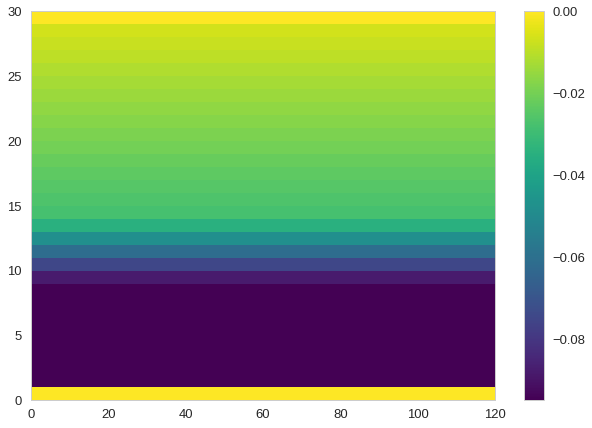

In [15]:
bathy_fname = 'tank/coarse_no_canyons.bin'
dx_fname = 'tank/coarse_dx.bin'
dy_fname = 'tank/coarse_dy.bin'

dt = np.dtype('>f8')  # float 64 big endian

fileobj = open(dx_fname,mode='wb')
del_th.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(dy_fname, mode='wb')
del_r.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(bathy_fname, mode='wb')
dd=np.transpose(topography)
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

plt.pcolor(dd, cmap='viridis')
plt.colorbar()


In [16]:
np.shape(del_r)

(30,)

In [17]:
np.shape(del_th)

(120,)

In [18]:
del_r

array([0.0137931, 0.0137931, 0.0137931, 0.0137931, 0.0137931, 0.0137931,
       0.0137931, 0.0137931, 0.0137931, 0.0137931, 0.0137931, 0.0137931,
       0.0137931, 0.0137931, 0.0137931, 0.0137931, 0.0137931, 0.0137931,
       0.0137931, 0.0137931, 0.0137931, 0.0137931, 0.0137931, 0.0137931,
       0.0137931, 0.0137931, 0.0137931, 0.0137931, 0.0137931, 0.0137931])

In [19]:
del_th

array([3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521008,
       3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521008,
       3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521008,
       3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521008,
       3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521008,
       3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521008,
       3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521008,
       3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521008,
       3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521008,
       3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521008,
       3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521008,
       3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521008,
       3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521008,
       3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521008,
       3.02521008, 3.02521008, 3.02521008, 3.02521008, 3.02521

**Check that bin file works when read by fortran**

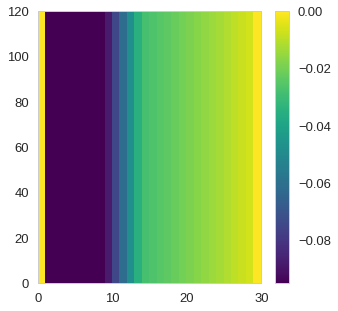

In [21]:
cc=np.fromfile(bathy_fname, dtype=dt)
np.shape(cc)

bF=np.reshape(cc,[thsize,rsize],'F') # F to read in Fortran order

fig,ax = plt.subplots(1,1, figsize=(5,5))

pc = ax.pcolormesh(bF, cmap='viridis')
plt.colorbar(pc,ax=ax)


Compare vs. bathymetry in rotating tank tutorial 

(2760,)


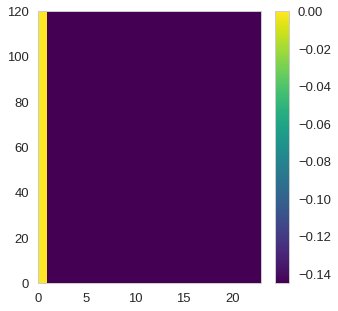

In [22]:
dt = np.dtype('>f4')  # float 32 big endian

cc=np.fromfile('/home/kramosmu/MITgcm/verification/rotating_tank/input/bathyPolR.bin', dtype=dt)
print(np.shape(cc))

bF=np.reshape(cc,[120,23],'F') # F to read in Fortran order

fig,ax = plt.subplots(1,1, figsize=(5,5))

pc = ax.pcolormesh(bF, cmap='viridis')
plt.colorbar(pc,ax=ax)